Merging DCT volumes
==

*Merging strategy:* look at overlapping region: determine center of mass for each grain restricted to this region (ie grain may be cut along Z). Find matching grains between the two sets of grains based on their respective orientation. Than find optimal rigid body transform between the two volumes. At this point the merging can be done in the following way: t5_dct_cen_ is taken as the reference (ids will not change within this volume). Additional volume are tranfsormed using the rigid body transformation found and merged. grains with a match in the reference volume are renumbered accordingly and other grains are renumbered consecutively to the last grain present. For each pixel in the overlapping region: if bothe pixel have the same label, it is preserved, it one pixel has a label and the other one is zero, the label is preserved. If both pixels are zero or non-zero, the voxel is set to zero.

3 scans: t5_dct_bot_, t5_dct_cen_, t5_dct_cen_1_, t5_dct_top_ 

samtz = -4.30922, -4.8095, -4.71812, -5.2102

Step by step example
==

In [3]:
from pymicro.crystal.microstructure import Microstructure, Orientation, Grain
from pymicro.crystal.lattice import Lattice, HklPlane, Symmetry
from pymicro.xray.experiment import Experiment
from pymicro.xray.detectors import RegArrayDetector2d
import numpy as np
import os

exp = Experiment.load('t5_experiment.txt')
Ti7Al = exp.get_sample().get_material()

use_mask = True

In [26]:
# scan list, starting with reference scan
#scan_list = ['t5_dct_bot_', 't5_dct_cen_']
#samtz_list = [-4.30922, -4.8095]
scan_list = ['t5_dct_cen_', 't5_dct_top_']
samtz_list = [-4.8095, -5.2102]

scan_shapes = []  # warning, shapes will be in (z, y, x) form
micros = []

In [27]:
import h5py
for scan in scan_list:
    with h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan) as f:
        scan_shapes.append(f['vol'].shape)
        print(f['vol'].shape)

(420, 654, 654)
(424, 648, 648)


In [28]:
# figure out the minimum cross section
min_shape = np.array(scan_shapes).min(axis=0)
max_shape = np.array(scan_shapes).max(axis=0)
print(min_shape)
print(max_shape)
offset = max_shape - min_shape
offset[0] = 0
padding = [(o // 2, o // 2) for o in offset]
print(padding)

[420 648 648]
[424 654 654]
[(0, 0), (3, 3), (3, 3)]


In [29]:
for scan in scan_list:
    # read microstructure for this scan
    print('processing scan %s' % scan)
    data_dir = os.path.join('id11', 't5_', scan)

    rod_path = os.path.join(data_dir, '4_grains/phase_01/R_vectors.txt')
    orientations = Orientation.read_orientations(rod_path, data_type='rodrigues', delimiter=',')
    center_path = os.path.join(data_dir, '4_grains/phase_01/grain_centers.txt')
    centers = np.genfromtxt(center_path, delimiter=',')
    micro = Microstructure(name=scan)
    for i in range(len(orientations)):
        gid = i + 1
        g = Grain(gid, orientations[gid])
        g.position = centers[i]
        g.center = centers[i]
        micro.grains.append(g)

    # add grain ids field, crop the (X, Y) dims
    f = h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan)
    print('vol shape is {}'.format(f['vol'].shape))
    offset = max_shape - f['vol'].shape
    offset[0] = 0
    padding = [(o // 2, o // 2) for o in offset]

    #ofy = (dims[1] - min_shape[1]) // 2
    #ofx = (dims[2] - min_shape[2]) // 2
    print('padding is {}'.format(padding))
    micro.grain_map = np.pad(f['vol'][()], padding, mode='constant').transpose(2, 1, 0)
    f.close()
    if use_mask:
        print('using mask')
        # also load the mask
        f = h5py.File('id11/t5_/%s/5_reconstruction/volume_mask.mat' % scan)
        micro.mask = np.pad(f['vol'][()], padding, mode='constant').transpose(2, 1, 0)
        f.close()
    micros.append(micro)

processing scan t5_dct_cen_
vol shape is (420, 654, 654)
padding is [(0, 0), (0, 0), (0, 0)]
using mask
processing scan t5_dct_top_
vol shape is (424, 648, 648)
padding is [(0, 0), (3, 3), (3, 3)]
using mask


In [30]:
# find out the overlap region (based on the difference in samtz)
voxel_size = exp.get_active_detector().get_pixel_size()
overlap_from_samtz = int(((samtz_list[1] + scan_shapes[1][0] // 2 * voxel_size) 
               - (samtz_list[0] - scan_shapes[0][0] // 2 * voxel_size))/ voxel_size)
print('vertical overlap is %d voxels' % overlap_from_samtz)
overlap = overlap_from_samtz  # you can specify a value to use here
print('using an actual overlap of %d voxels' % overlap)

vertical overlap is 135 voxels
using an actual overlap of 135 voxels


In [31]:
# create two microstructure of the overlapping regions: end slices in first scan and first slices in second scan
grain_ids_ol1 = micros[0].grain_map[:, :, scan_shapes[0][0]-overlap:]
grain_ids_ol2 = micros[1].grain_map[:, :, :overlap]
dims_ol1 = np.array(grain_ids_ol1.shape)
print(dims_ol1)
dims_ol2 = np.array(grain_ids_ol2.shape)
print(dims_ol2)

[654 654 135]
[654 654 135]


In [51]:
i = 1
(2 * i + 1) * voxel_size * 0.5 * (np.array(grain_ids_ols[i].shape) - np.array(micros[i].grain_map.shape))

array([ 0.    ,  0.    , -0.6069])

In [52]:
from scipy import ndimage

grain_ids_ols = [grain_ids_ol1, grain_ids_ol2]
micros_ol = []
for i in range(2):
    grain_ids_ol = grain_ids_ols[i]
    ids_ol = np.unique(grain_ids_ol)
    print(ids_ol)

    # difference due to the crop (restricting the grain map to the overlap region)
    offset = voxel_size * 0.5 * (np.array(grain_ids_ol.shape) - np.array(micros[i].grain_map.shape))
    offset *= (2 * i - 1)  # offset is positive for i = 0, negative for i = 1
    print('offset [mm] is {}'.format(offset))

    # read microstructure for bot scan
    micro_ol = Microstructure(name='%sol_' % scan_list[i])
    print('* building microstructure %s' % micro_ol.name)
    micro_ol.grain_map = grain_ids_ol
    for gid in ids_ol:
        if gid < 1:
            print('skipping %d' % gid)
            continue
        g = Grain(gid, micros[i].get_grain(gid).orientation)
        # recalculate position as we look at a truncated volume
        array_bin = (grain_ids_ol == gid).astype(np.uint8)
        local_com = ndimage.measurements.center_of_mass(array_bin, grain_ids_ol)
        com_mm = voxel_size * (local_com - 0.5 * np.array(grain_ids_ol.shape)) + offset
        print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))
        g.position = com_mm
        g.center = com_mm
        micro_ol.grains.append(g)
    # add the overlap microstructure to the list
    micros_ol.append(micro_ol)

[ -1   0   2   4   8  11  12  13  15  19  21  24  26  27  28  29  30  31
  33  34  36  38  39  41  42  43  44  46  49  53  55  56  58  59  61  62
  64  67  72  73  74  75  76  77  78  79  80  83  84  86  87  91  94  95
  99 101 104 106 107 111 116 119 120 121 123 125 128 133 136 140 142 144
 146]
offset [mm] is [-0.     -0.      0.1995]
* building microstructure t5_dct_cen_ol_
skipping -1
skipping 0
grain  2 position: -0.010,  0.140,  0.120
grain  4 position: -0.057, -0.118,  0.141
grain  8 position:  0.293,  0.110,  0.127
grain 11 position:  0.107,  0.211,  0.157
grain 12 position:  0.146, -0.093,  0.189
grain 13 position: -0.212,  0.194,  0.125
grain 15 position:  0.056, -0.230,  0.157
grain 19 position:  0.211, -0.034,  0.105
grain 21 position:  0.190, -0.197,  0.121
grain 24 position: -0.217,  0.015,  0.124
grain 26 position:  0.283, -0.253,  0.105
grain 27 position:  0.246,  0.098,  0.209
grain 28 position:  0.001,  0.034,  0.157
grain 29 position: -0.276, -0.178,  0.186
grain 30 

In [53]:
len(micros_ol[0].grains)

71

In [54]:
# match grain from micros_ol[1] to micros_ol[0] (the reference)
matched, _, unmatched = micros_ol[0].match_grains(micros_ol[1], verbose=True)

grain   2 -- candidate:  68, misorientation: 0.08 deg
grain   4 -- candidate:  28, misorientation: 0.04 deg
grain   8 -- candidate:  53, misorientation: 0.05 deg
grain  11 -- candidate:  21, misorientation: 0.04 deg
grain  12 -- candidate:  10, misorientation: 0.04 deg
grain  13 -- candidate:  64, misorientation: 0.04 deg
grain  15 -- candidate:  32, misorientation: 0.03 deg
grain  19 -- candidate: 128, misorientation: 0.05 deg
grain  21 -- candidate:  87, misorientation: 0.04 deg
grain  24 -- candidate:  67, misorientation: 0.02 deg
grain  26 -- candidate: 137, misorientation: 0.04 deg
grain  27 -- candidate:  14, misorientation: 0.03 deg
grain  28 -- candidate:  35, misorientation: 0.03 deg
grain  29 -- candidate:  19, misorientation: 0.01 deg
grain  30 -- candidate:  34, misorientation: 0.03 deg
grain  31 -- candidate:  45, misorientation: 0.03 deg
grain  33 -- candidate:  22, misorientation: 0.01 deg
grain  34 -- candidate:   4, misorientation: 0.07 deg
grain  36 -- candidate:  30,

In [55]:
print(len(matched))
print(matched)
i = 1
print(micros_ol[0].get_grain(matched[i][0]).center)
print(micros_ol[1].get_grain(matched[i][1]).center)

70
[[2, 68], [4, 28], [8, 53], [11, 21], [12, 10], [13, 64], [15, 32], [19, 128], [21, 87], [24, 67], [26, 137], [27, 14], [28, 35], [29, 19], [30, 34], [31, 45], [33, 22], [34, 4], [36, 30], [38, 23], [39, 50], [41, 55], [42, 29], [43, 26], [44, 57], [46, 52], [49, 47], [53, 62], [55, 17], [56, 104], [58, 78], [59, 82], [61, 58], [62, 138], [64, 27], [67, 76], [72, 80], [73, 108], [74, 85], [75, 86], [76, 139], [77, 39], [78, 94], [79, 90], [80, 101], [83, 96], [84, 42], [86, 33], [87, 99], [94, 102], [95, 7], [99, 79], [101, 77], [104, 13], [106, 106], [107, 48], [111, 69], [116, 116], [119, 112], [120, 120], [121, 51], [123, 119], [125, 107], [128, 54], [133, 24], [136, 36], [140, 43], [142, 92], [144, 144], [146, 113]]
[-0.05659913 -0.11803333  0.14143679]
[-0.0657917  -0.1181255  -0.24860989]


In [56]:
unmatched

[91]

In [57]:
from pymicro.view.vol_utils import compute_affine_transform

# compute the affine transform
n_points = len(matched)
fixed = np.zeros((n_points, 3))
moving = np.zeros((n_points, 3))
moved = np.zeros_like(moving)

# markers in t5_dct_bot_ol_
for i in range(n_points):
    fixed[i] = micros_ol[0].get_grain(matched[i][0]).center
    moving[i] = micros_ol[1].get_grain(matched[i][1]).center

# call the registration method
translation, transformation = compute_affine_transform(fixed, moving)
invt = np.linalg.inv(transformation)

# check what are now the points after transformation
fixed_centroid = np.average(fixed, axis=0)
moving_centroid = np.average(moving, axis=0)
print('fixed centroid: {}'.format(fixed_centroid))
print('moving centroid: {}'.format(moving_centroid))

for j in range(n_points):
  moved[j] = fixed_centroid + np.dot(transformation, moving[j] - moving_centroid)
  print('point %d will move to (%6.3f, %6.3f, %6.3f) to be compared with (%6.3f, %6.3f, %6.3f)' % (j, moved[j, 0], moved[j, 1], moved[j, 2], fixed[j, 0], fixed[j, 1], fixed[j, 2]))
print('transformation is:')
print(invt)

# offset and translation, here we only look for rigid body translation
offset = -np.dot(invt, translation)
print(translation, offset)
translation_voxel = (translation / voxel_size).astype(int)
print(translation_voxel)

fixed centroid: [-0.01316453  0.02228897  0.19991359]
moving centroid: [-0.02692876  0.0223395  -0.18699797]
point 0 will move to (-0.012,  0.134,  0.116) to be compared with (-0.010,  0.140,  0.120)
point 1 will move to (-0.052, -0.118,  0.140) to be compared with (-0.057, -0.118,  0.141)
point 2 will move to ( 0.292,  0.109,  0.125) to be compared with ( 0.293,  0.110,  0.127)
point 3 will move to ( 0.110,  0.213,  0.160) to be compared with ( 0.107,  0.211,  0.157)
point 4 will move to ( 0.147, -0.095,  0.194) to be compared with ( 0.146, -0.093,  0.189)
point 5 will move to (-0.210,  0.195,  0.123) to be compared with (-0.212,  0.194,  0.125)
point 6 will move to ( 0.056, -0.230,  0.155) to be compared with ( 0.056, -0.230,  0.157)
point 7 will move to ( 0.197, -0.032,  0.101) to be compared with ( 0.211, -0.034,  0.105)
point 8 will move to ( 0.193, -0.195,  0.119) to be compared with ( 0.190, -0.197,  0.121)
point 9 will move to (-0.216,  0.015,  0.122) to be compared with (-0.21

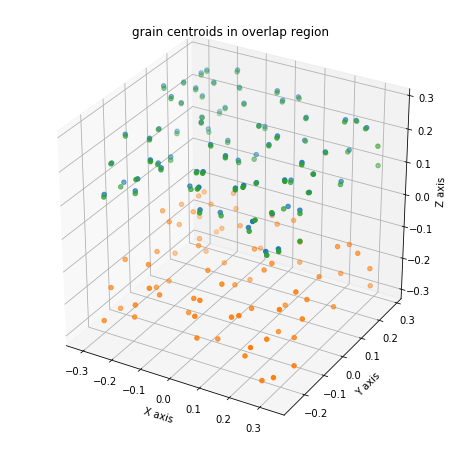

In [58]:
from matplotlib import pyplot as plt, cm
%matplotlib inline
from mpl_toolkits import mplot3d

# plot the grain centroids in 3D
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
# plot grain centroids in reference micros_ol
g_center_x = [g.center[0] for g in micros_ol[0].grains] 
g_center_y = [g.center[1] for g in micros_ol[0].grains] 
g_center_z = [g.center[2] for g in micros_ol[0].grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
# plot grain centroids in micro_cen_ol
g_center_x = [g.center[0] for g in micros_ol[1].grains] 
g_center_y = [g.center[1] for g in micros_ol[1].grains] 
g_center_z = [g.center[2] for g in micros_ol[1].grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
# now plot moved grain centroids
g_center_x = [g.center[0] + translation[0] for g in micros_ol[1].grains] 
g_center_y = [g.center[1] + translation[1] for g in micros_ol[1].grains] 
g_center_z = [g.center[2] + translation[2] for g in micros_ol[1].grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('grain centroids in overlap region')
plt.show()

In [60]:
# look at ids in the reference volume
ids_ref = np.unique(micros[0].grain_map)
ids_ref_list = ids_ref.tolist()
ids_ref_list.remove(-1)  # grain overlap
ids_ref_list.remove(0)  # background
print(ids_ref_list)
id_offset = max(ids_ref_list)
print('grain ids in volume %s will be offset by %d' % (micros[1].name, id_offset))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146]
grain ids in volume t5_dct_top_ will be offset by 146


In [66]:
# gather ids in the merging volume (will be modified)
ids_mrg = np.unique(micros[1].grain_map)
ids_mrg_list = ids_mrg.tolist()
ids_mrg_list.remove(-1)  # grain overlap
ids_mrg_list.remove(0)  # background
print(ids_mrg_list)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]


In [67]:
# prepare a volume with the same size as the second grain map, with grain ids renumbered and (X, Y) translations applied. 
grain_map_translated = micros[1].grain_map.copy()
print('renumbering grains in the overlap region of volume %s' % micros[1].name)
for match in matched:
    ref_id, other_id = match
    print('replacing %d by %d' % (other_id, ref_id))
    grain_map_translated[micros[1].grain_map == other_id] = ref_id
    ids_mrg_list.remove(other_id)
# also renumber the rest using the offset
renumbered_grains = []
for i, other_id in enumerate(ids_mrg_list):
    new_id = id_offset + i + 1
    grain_map_translated[micros[1].grain_map == other_id] = new_id
    print('replacing %d by %d' % (other_id, new_id))
    renumbered_grains.append([other_id, new_id])


renumbering grains in the overlap region of volume t5_dct_top_
replacing 68 by 2
replacing 28 by 4
replacing 53 by 8
replacing 21 by 11
replacing 10 by 12
replacing 64 by 13
replacing 32 by 15
replacing 128 by 19
replacing 87 by 21
replacing 67 by 24
replacing 137 by 26
replacing 14 by 27
replacing 35 by 28
replacing 19 by 29
replacing 34 by 30
replacing 45 by 31
replacing 22 by 33
replacing 4 by 34
replacing 30 by 36
replacing 23 by 38
replacing 50 by 39
replacing 55 by 41
replacing 29 by 42
replacing 26 by 43
replacing 57 by 44
replacing 52 by 46
replacing 47 by 49
replacing 62 by 53
replacing 17 by 55
replacing 104 by 56
replacing 78 by 58
replacing 82 by 59
replacing 58 by 61
replacing 138 by 62
replacing 27 by 64
replacing 76 by 67
replacing 80 by 72
replacing 108 by 73
replacing 85 by 74
replacing 86 by 75
replacing 139 by 76
replacing 39 by 77
replacing 94 by 78
replacing 90 by 79
replacing 101 by 80
replacing 96 by 83
replacing 42 by 84
replacing 33 by 86
replacing 99 by 87
rep

In [68]:
# apply translation along the (X, Y) axes
grain_map_translated = np.roll(grain_map_translated, translation_voxel[:2], (0, 1))

(654, 654, 424)
135
297


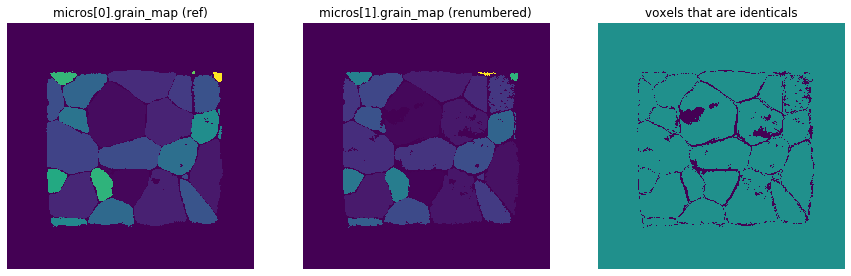

In [69]:
check = 25
print(grain_map_translated.shape)
print(overlap)
print(translation_voxel[2] + check)
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(micros[0].grain_map[:, :, translation_voxel[2] + check].T, vmin=0)
plt.axis('off')
plt.title('micros[0].grain_map (ref)')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(grain_map_translated[:, :, check].T, vmin=0)
plt.axis('off')
plt.title('micros[1].grain_map (renumbered)')
ax3 = fig.add_subplot(1, 3, 3)
same = micros[0].grain_map[:, :, translation_voxel[2] + check] == grain_map_translated[:, :, check]
ax3.imshow(same.T, vmin=0, vmax=2)
plt.axis('off')
plt.title('voxels that are identicals')
plt.show()

overlap is 148 voxels
vertical size will be: 272 + 148 + 276 = 696
initializing volume with shape [654 654 696]
(654, 654, 420)
(654, 654, 424)
(654, 654, 148)
(654, 654, 148)
translation_voxel[2] = 272
micros[0].grain_map.shape[2] - overlap = 272
(654, 654, 148)
(654, 654, 148)
(654, 654, 148)


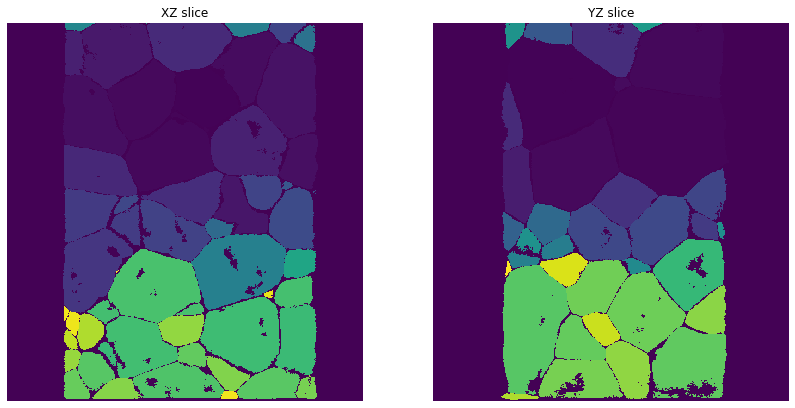

In [81]:
# start the merging: the first volume is the reference, translation_voxel is (12, 0, 368)
overlap = micros[0].grain_map.shape[2] - translation_voxel[2]
print('overlap is %d voxels' % overlap)
z_shape = micros[0].grain_map.shape[2] + micros[1].grain_map.shape[2] - overlap
print('vertical size will be: %d + %d + %d = %d' % (micros[0].grain_map.shape[2] - overlap, overlap, micros[1].grain_map.shape[2] - overlap, z_shape))
shape_merged = np.array(micros[0].grain_map.shape) + [0, 0, micros[1].grain_map.shape[2] - overlap]
print('initializing volume with shape {}'.format(shape_merged))
grain_ids_merged = np.zeros(shape_merged, dtype=np.int16)
print(micros[0].grain_map.shape)
print(micros[1].grain_map.shape)

# add the non-overlapping part of the 2 volumes as is
grain_ids_merged[:, :, :micros[0].grain_map.shape[2] - overlap] = micros[0].grain_map[:, :, :-overlap]
grain_ids_merged[:, :, micros[0].grain_map.shape[2]:] = grain_map_translated[:, :, overlap:]

# look at vertices with the same label 
print(micros[0].grain_map[:, :, translation_voxel[2]:].shape)
print(grain_map_translated[:, :, :overlap].shape)
print('translation_voxel[2] = %d' % translation_voxel[2])
print('micros[0].grain_map.shape[2] - overlap = %d' % (micros[0].grain_map.shape[2] - overlap))
same_voxels = micros[0].grain_map[:, :, translation_voxel[2]:] == grain_map_translated[:, :, :overlap]
print(same_voxels.shape)
grain_ids_merged[:, :, translation_voxel[2]:micros[0].grain_map.shape[2]] = grain_map_translated[:, :, :overlap] * same_voxels

# look at vertices with a single label 
single_voxels_0 = (micros[0].grain_map[:, :, translation_voxel[2]:] > 0) & (grain_map_translated[:, :, :overlap] == 0)
print(single_voxels_0.shape)
grain_ids_merged[:, :, translation_voxel[2]:micros[0].grain_map.shape[2]] += micros[0].grain_map[:, :, translation_voxel[2]:] * single_voxels_0
single_voxels_1 = (grain_map_translated[:, :, :overlap] > 0) & (micros[0].grain_map[:, :, translation_voxel[2]:] == 0)
print(single_voxels_1.shape)
grain_ids_merged[:, :, translation_voxel[2]:micros[0].grain_map.shape[2]] += grain_map_translated[:, :, :overlap] * single_voxels_1

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(grain_ids_merged[:, 320, :].T)
plt.axis('off')
plt.title('XZ slice')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(grain_ids_merged[320, :, :].T)
plt.axis('off')
plt.title('YZ slice')
plt.show()

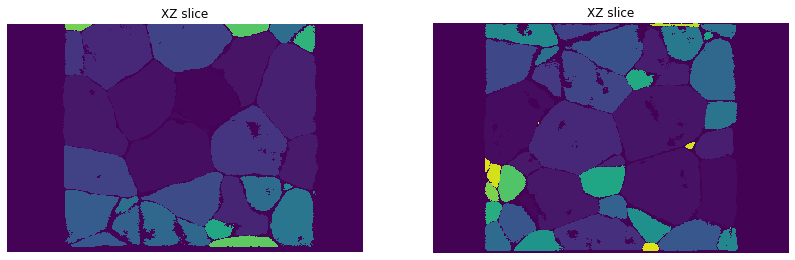

In [74]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(micros[0].grain_map[:, 320, :].T)
plt.axis('off')
plt.title('XZ slice')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(micros[1].grain_map[:, 320, :].T)
plt.axis('off')
plt.title('XZ slice')
plt.show()

In [82]:
mask_translated = np.roll(micros[1].mask, translation_voxel[:2], (0, 1))

(654, 654, 148)
(654, 654, 148)
bool
(654, 654, 148)


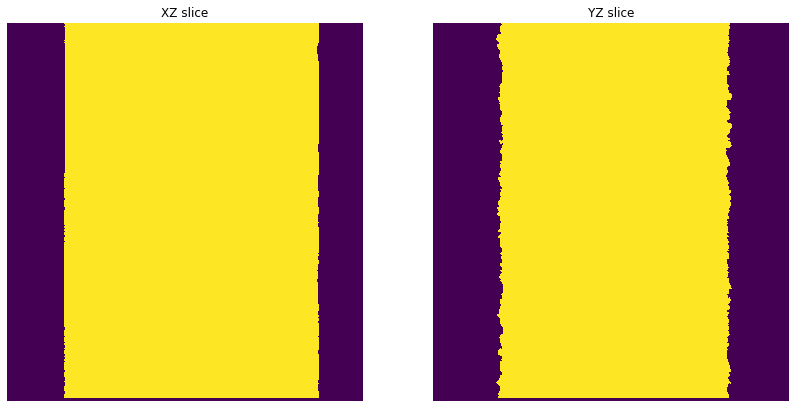

In [86]:
# merging the masks
mask_merged = np.zeros(shape_merged, dtype=np.uint8)
# add the non-overlapping part of the 2 volumes as is
mask_merged[:, :, :micros[0].mask.shape[2] - overlap] = micros[0].mask[:, :, :-overlap]
mask_merged[:, :, micros[0].grain_map.shape[2]:] = mask_translated[:, :, overlap:]

# look at vertices with the same label 
same_voxels = micros[0].mask[:, :, translation_voxel[2]:] == mask_translated[:, :, :overlap]
print(same_voxels.shape)
mask_merged[:, :, translation_voxel[2]:micros[0].mask.shape[2]] = mask_translated[:, :, :overlap] * same_voxels

# look at vertices with a single label 
single_voxels_0 = (micros[0].mask[:, :, translation_voxel[2]:] > 0) & (mask_translated[:, :, :overlap] == 0)
mask_merged[:, :, translation_voxel[2]:micros[0].mask.shape[2]] += (micros[0].mask[:, :, translation_voxel[2]:] * single_voxels_0).astype(np.uint8)
single_voxels_1 = (mask_translated[:, :, :overlap] > 0) & (micros[0].mask[:, :, translation_voxel[2]:] == 0)
mask_merged[:, :, translation_voxel[2]:micros[0].mask.shape[2]] += (mask_translated[:, :, :overlap] * single_voxels_1).astype(np.uint8)

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(mask_merged[:, 320, :].T)
plt.axis('off')
plt.title('XZ slice')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask_merged[320, :, :].T)
plt.axis('off')
plt.title('YZ slice')
plt.show()

In [179]:
# write the merged grain ids and mask as a single .h5 file
import h5py
f = h5py.File('id11/t5_/phase_01_vol.h5', 'w')
f.create_dataset('vol', data=grain_ids_merged.transpose(2, 1, 0), compression='gzip', compression_opts=9)
f.create_dataset('mask', data=mask_merged.transpose(2, 1, 0), compression='gzip', compression_opts=9)
print(f.keys())
f.close()
# warning this is different than when using the merge_dct_scans function, the h5 file structure is different.

<KeysViewHDF5 ['mask', 'vol']>


Fully automated function
==

In [1]:
from pymicro.xray.experiment import Experiment
from pymicro.xray.dct import merge_dct_scans

exp = Experiment.load('t5_experiment.txt')
Ti7Al = exp.get_sample().get_material()
voxel_size = exp.get_active_detector().get_pixel_size()

scan_list = ['t5_dct_bot_', 't5_dct_cen_']
samtz_list = [-4.30922, -4.8095]

merge_dct_scans(scan_list, samtz_list, voxel_size, use_mask=True, overlap=47, root_dir='id11/t5_')

/home/proudhon/python/pymicro/pymicro/external/tifffile.py:298: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


(414, 676, 676)
(420, 654, 654)
processing scan t5_dct_bot_
creating microstructure for DCT scan t5_dct_bot_
id11/t5_/t5_dct_bot_/4_grains/phase_01/index.mat
creating crystal lattice Ti7Al (Symmetry.hexagonal) with parameters [  2.929   2.929   4.675  90.     90.    120.   ]


/home/proudhon/python/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


loaded volume with shape: (676, 676, 414)
loaded volume with shape: (676, 676, 414)
vol shape is (676, 676, 414)
padding is [(0, 0), (0, 0), (0, 0)]
processing scan t5_dct_cen_
creating microstructure for DCT scan t5_dct_cen_
id11/t5_/t5_dct_cen_/4_grains/phase_01/index.mat
creating crystal lattice Ti7Al (Symmetry.hexagonal) with parameters [  2.929   2.929   4.675  90.     90.    120.   ]
loaded volume with shape: (654, 654, 420)
loaded volume with shape: (654, 654, 420)
vol shape is (654, 654, 420)
padding is [(11, 11), (11, 11), (0, 0)]
vertical overlap deduced from samtz positions is 59 voxels
using an actual overlap of 47 voxels
[676 676  47]
[676 676  47]
[ -1   0   2   4  11  12  16  21  22  26  27  32  35  38  39  41  42  46
  53  55  58  60  64  71  74  77  79  81  88  93 102 111 114 118 119 124
 128 129 130 133 135 137 143 147 148 154 155 161 164]
offset [px] is [ -0.  -0. 367.]
offset [mm] is [-0.     -0.      0.5138]
* building microstructure t5_dct_bot_ol_
skipping -1
skip

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
grain ids in volume t5_dct_cen_ will be offset by 165
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6

done writing


In [13]:
from pymicro.crystal.microstructure import Microstructure
m = Microstructure.from_h5('t5_dct_bot_-t5_dct_cen_.h5')

some grains
(262, 3)


In [23]:
import h5py
f = h5py.File('t5_dct_bot_-t5_dct_cen_.h5')
print(f.keys())
print(f['FeatureData'].keys())
grain_ids = f['FeatureData/grain_ids'][()]
print(grain_ids)
print(f['CellData'].keys())
f.close()

<KeysViewHDF5 ['CellData', 'EnsembleData', 'FeatureData']>
<KeysViewHDF5 ['R_vectors', 'centers', 'grain_ids']>
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219

In [19]:
print(len(m.grains))
print(m.get_grain(1))
print(m.grain_map.shape)
print(m.mask.shape)

262
Grain
 * id = 1
 * Crystal Orientation
orientation matrix = [[ 0.1816716   0.02671399  0.98299636]
 [-0.49449081  0.86653135  0.06783997]
 [-0.8499849  -0.49840725  0.17063396]]
Euler angles (degrees) = ( 300.386,  80.175,  86.052)
Rodrigues vector = [ 0.25520002 -0.82610004  0.23490001]
Quaternion = [ 0.74478804 -0.19006992  0.61526941  0.17495071]
 * position [ 0.0543  0.0573 -0.0404]
 * has vtk mesh ? False

(676, 676, 788)
(676, 676, 788)


Debug
==

In [6]:
# debug center of mass problem
from pymicro.crystal.microstructure import Microstructure, Orientation, Grain
from pymicro.xray.experiment import Experiment
import numpy as np
import os
import h5py
from scipy import ndimage
lattice=Ti7Al
use_mask = True

scan_shapes = []  # warning, shapes will be in (z, y, x) form
micros = []

for scan in scan_list:
    with h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan) as f:
        scan_shapes.append(f['vol'].shape)
        print(f['vol'].shape)

# figure out the maximum cross section
max_shape = np.array(scan_shapes).max(axis=0)
print(max_shape)

for scan in scan_list:
    # read microstructure for this scan
    print('processing scan %s' % scan)
    data_dir = os.path.join('id11', 't5_', scan)

    rod_path = os.path.join(data_dir, '4_grains/phase_01/R_vectors.txt')
    orientations = Orientation.read_orientations(rod_path, data_type='rodrigues', delimiter=',')
    center_path = os.path.join(data_dir, '4_grains/phase_01/grain_centers.txt')
    centers = np.genfromtxt(center_path, delimiter=',')
    micro = Microstructure(name=scan)
    micro.set_lattice(lattice)
    for i in range(len(orientations)):
        gid = i + 1
        g = Grain(gid, orientations[gid])
        g.position = centers[i]
        g.center = centers[i]
        micro.grains.append(g)

    # add grain ids field, crop the (X, Y) dims
    f = h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan)
    print('vol shape is {}'.format(f['vol'].shape))
    offset = max_shape - f['vol'].shape
    offset[0] = 0
    padding = [(o // 2, o // 2) for o in offset]
    print('padding is {}'.format(padding))
    micro.grain_map = np.pad(f['vol'][()], padding, mode='constant').transpose(2, 1, 0)
    f.close()
    if use_mask:
        print('using mask')
        # also load the mask
        f = h5py.File('id11/t5_/%s/5_reconstruction/volume_mask.mat' % scan)
        micro.mask = np.pad(f['vol'][()], padding, mode='constant').transpose(2, 1, 0)
        f.close()
    micros.append(micro)


(420, 654, 654)
(424, 648, 648)
[424 654 654]
processing scan t5_dct_cen_
vol shape is (420, 654, 654)
padding is [(0, 0), (0, 0), (0, 0)]
using mask
processing scan t5_dct_top_
vol shape is (424, 648, 648)
padding is [(0, 0), (3, 3), (3, 3)]
using mask


In [7]:
print(micros[0].grain_map.shape)
for gid in [2, 4, 11, 12, 16, 21, 22, 26, 27, 32, 35, 38, 39, 41, 42, 46, 
           53, 55, 58, 59, 60, 64, 67, 71, 74, 77, 79, 81, 88, 93, 102, 111, 114, 118]:
    print(gid, micros[0].get_grain(gid).center)
gid = 2
# look at the grain in the complete volume
array_bin = (micros[0].grain_map == gid).astype(np.uint8)
local_com = ndimage.measurements.center_of_mass(array_bin, micros[0].grain_map)
print('local_com = {}'.format(local_com))
com_px = (local_com - 0.5 * np.array(micros[0].grain_map.shape))
print('com [px] = {}'.format(com_px))
com_mm = voxel_size * com_px
print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))

(654, 654, 420)
2 [-0.0244  0.1437 -0.0065]
4 [-0.0515 -0.0963  0.0776]
11 [0.1159 0.2157 0.1281]
12 [ 0.1431 -0.0943  0.1782]
16 [-0.2408  0.2406 -0.0977]
21 [ 0.1911 -0.1874  0.0589]
22 [ 0.0975  0.2436 -0.1864]
26 [ 0.2833 -0.2145 -0.0087]
27 [0.2444 0.0991 0.2065]
32 [ 0.2238  0.24   -0.1589]
35 [ 0.254   0.2578 -0.0032]
38 [-0.1444  0.0609  0.2217]
39 [-0.1799 -0.2074  0.1227]
41 [-0.0578  0.2516  0.1301]
42 [-0.042  -0.0426  0.2294]
46 [-0.1926 -0.0875  0.1551]
53 [ 0.3178 -0.0973  0.2015]
55 [0.1319 0.1738 0.249 ]
58 [-0.1353 -0.246   0.2057]
59 [ 0.2799 -0.0776  0.1121]
60 [ 0.2951  0.2222 -0.2494]
64 [0.2614 0.2345 0.2398]
67 [-0.0027 -0.1619  0.2174]
71 [-0.1942  0.2055 -0.2862]
74 [-0.2017  0.1466  0.1847]
77 [-0.2958  0.1928  0.2489]
79 [-0.1874  0.2442  0.1713]
81 [ 0.1545  0.2785 -0.0525]
88 [ 0.1498 -0.2444 -0.0148]
93 [ 0.144   0.0095 -0.2879]
102 [ 0.0048 -0.2546 -0.2746]
111 [-0.23    0.1577  0.2628]
114 [-0.1042  0.2889 -0.01  ]
118 [ 0.1085 -0.2525 -0.259 ]
local_co

In [8]:
grain_ids_ol = micros[0].grain_map[:, :, micros[0].grain_map.shape[2] - 59:]
#grain_ids_ol = micros[0].grain_map[:, :, -47:]

offset_px = -1 * np.array([0., 0., grain_ids_ol.shape[2] - micros[0].grain_map.shape[2]])
print('offset [px] is {}'.format(offset_px))

array_bin = (grain_ids_ol == gid).astype(np.uint8)
local_com = ndimage.measurements.center_of_mass(array_bin, grain_ids_ol)
print('local_com = {}'.format(local_com))
com_px = (local_com + offset_px - 0.5 * np.array(micros[0].grain_map.shape))
print('com [px] = {}'.format(com_px))
com_mm = voxel_size * com_px
print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))


offset [px] is [ -0.  -0. 361.]


/home/proudhon/python/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


local_com = (nan, nan, nan)
com [px] = [nan nan nan]
grain  2 position:    nan,    nan,    nan


In [10]:
print(micros[1].grain_map.shape)
for gid in [2, 118]:
    print(gid, micros[1].get_grain(gid).center)
gid = 2
# look at the grain in the complete volume
array_bin = (micros[1].grain_map == gid).astype(np.uint8)
local_com = ndimage.measurements.center_of_mass(array_bin, micros[1].grain_map)
print('local_com = {}'.format(local_com))
com_px = (local_com - 0.5 * np.array(micros[1].grain_map.shape))
print('com [px] = {}'.format(com_px))
com_mm = voxel_size * com_px
print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))

(654, 654, 424)
2 [-0.1827  0.1555  0.1624]
118 [-0.314  -0.225   0.1002]
local_com = (196.01874516196037, 438.54650294178737, 328.0153405648612)
com [px] = [-130.98125484  111.54650294  116.01534056]
grain  2 position: -0.183,  0.156,  0.162


In [10]:
0.5 * np.array(micros[1].grain_map.shape)
25.32 - 210

-184.68

In [11]:
i = 1
grain_ids_ol = micros[i].grain_map[:, :, :59]

offset_px = (2 * i - 1) * np.array([0., 0., grain_ids_ol.shape[2] - micros[i].grain_map.shape[2]])
offset_mm = voxel_size * offset_px
print('offset [px] is {}'.format(offset_px))
print('offset [mm] is {}'.format(offset_mm))

array_bin = (grain_ids_ol == gid).astype(np.uint8)
local_com = ndimage.measurements.center_of_mass(array_bin, grain_ids_ol)
print('local_com = {}'.format(local_com))
com_px = (local_com - 0.5 * np.array(micros[i].grain_map.shape))
print('com [px] = {}'.format(com_px))
com_mm = voxel_size * com_px
print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))

offset [px] is [   0.    0. -361.]
offset [mm] is [ 0.      0.     -0.5054]
local_com = (416.2724821104347, 158.31330770052332, 25.352905051799638)
com [px] = [  78.27248211 -179.6866923  -184.64709495]
grain 118 position:  0.110, -0.252, -0.259


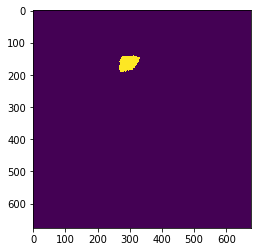

In [37]:
from matplotlib import pyplot as plt, cm
%matplotlib inline

plt.imshow((micros[0].grain_map[:, :, 410] == 118).T)

(420, 654, 654)
(424, 648, 648)
[424 654 654]
processing scan t5_dct_cen_
vol shape is (420, 654, 654)
padding is [(0, 0), (0, 0), (0, 0)]
using mask
processing scan t5_dct_top_
vol shape is (424, 648, 648)
padding is [(0, 0), (3, 3), (3, 3)]
using mask
vertical overlap deduced from samtz positions is 135 voxels
using an actual overlap of 135 voxels
[654 654 135]
[654 654 135]
[ -1   0   2   4   8  11  12  13  15  19  21  24  26  27  28  29  30  31
  33  34  36  38  39  41  42  43  44  46  49  53  55  56  58  59  61  62
  64  67  72  73  74  75  76  77  78  79  80  83  84  86  87  91  94  95
  99 101 104 106 107 111 116 119 120 121 123 125 128 133 136 140 142 144
 146]
offset [px] is [ -0.  -0. 285.]
offset [mm] is [-0.    -0.     0.399]
* building microstructure t5_dct_cen_ol_
skipping -1
skipping 0
grain  2 position: -0.010,  0.140,  0.120
grain  4 position: -0.057, -0.118,  0.141
grain  8 position:  0.293,  0.110,  0.127
grain 11 position:  0.107,  0.211,  0.157
grain 12 position:  

grain  33 -- candidate:  22, misorientation: 0.01 deg
grain  34 -- candidate:   4, misorientation: 0.07 deg
grain  36 -- candidate:  30, misorientation: 0.03 deg
grain  38 -- candidate:  23, misorientation: 0.01 deg
grain  39 -- candidate:  50, misorientation: 0.02 deg
grain  41 -- candidate:  55, misorientation: 0.04 deg
grain  42 -- candidate:  29, misorientation: 0.01 deg
grain  43 -- candidate:  26, misorientation: 0.01 deg
grain  44 -- candidate:  57, misorientation: 0.01 deg
grain  46 -- candidate:  52, misorientation: 0.02 deg
grain  49 -- candidate:  47, misorientation: 0.02 deg
grain  53 -- candidate:  62, misorientation: 0.02 deg
grain  55 -- candidate:  17, misorientation: 0.03 deg
grain  56 -- candidate: 104, misorientation: 0.03 deg
grain  58 -- candidate:  78, misorientation: 0.02 deg
grain  59 -- candidate:  82, misorientation: 0.02 deg
grain  61 -- candidate:  58, misorientation: 0.01 deg
grain  62 -- candidate: 138, misorientation: 0.02 deg
grain  64 -- candidate:  27,

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146]
grain ids in volume t5_dct_top_ will be offset by 146
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 

done writing


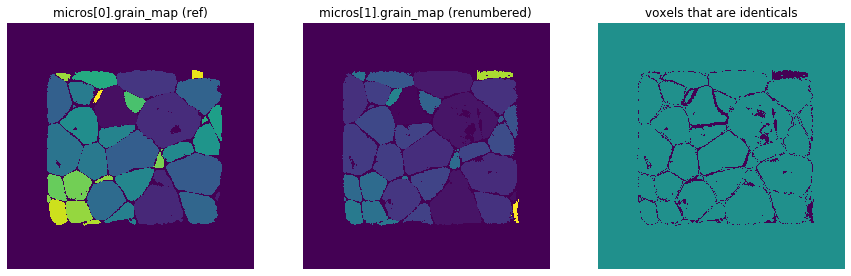

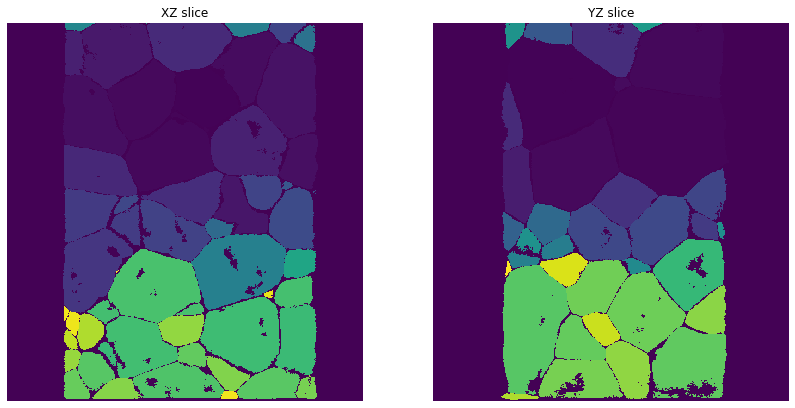

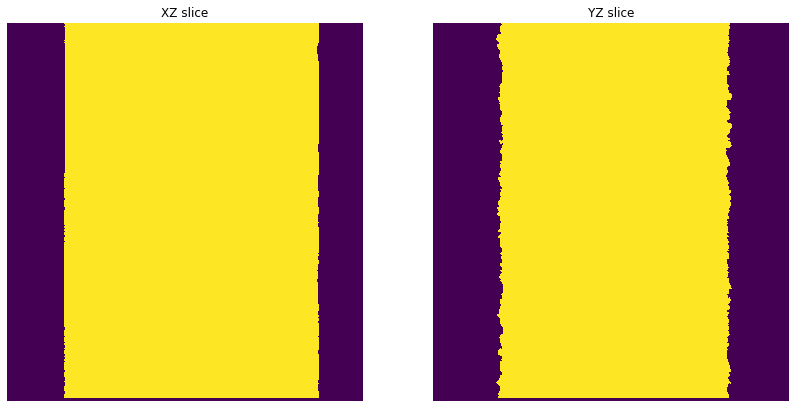

In [4]:
from pymicro.xray.experiment import Experiment
from pymicro.xray.dct import merge_dct_scans

exp = Experiment.load('t5_experiment.txt')
Ti7Al = exp.get_sample().get_material()
voxel_size = exp.get_active_detector().get_pixel_size()

scan_list = ['t5_dct_cen_', 't5_dct_top_']
samtz_list = [-4.8095, -5.2102]

merge_dct_scans(scan_list, samtz_list, use_mask=True, lattice=Ti7Al, voxel_size=voxel_size)

Merge the third scan
--

In [1]:
from pymicro.crystal.microstructure import Microstructure

micro_botcen = Microstructure.from_h5('t5_dct_bot_-t5_dct_cen_.h5')

some grains
(262, 3)


In [2]:
from pymicro.xray.experiment import Experiment

exp = Experiment.load('t5_experiment.txt')
Ti7Al = exp.get_sample().get_material()
voxel_size = exp.get_active_detector().get_pixel_size()

from pymicro.crystal.microstructure import Microstructure, Orientation, Grain
from pymicro.crystal.lattice import Lattice
import numpy as np
import os
import h5py
scan = 't5_dct_top_'

with h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan) as f:
    #scan_shapes.append(f['vol'].shape)
    print(f['vol'].shape)

print('processing scan %s' % scan)
data_dir = os.path.join('id11', 't5_', scan)

rod_path = os.path.join(data_dir, '4_grains/phase_01/R_vectors.txt')
orientations = Orientation.read_orientations(rod_path, data_type='rodrigues', delimiter=',')
center_path = os.path.join(data_dir, '4_grains/phase_01/grain_centers.txt')
centers = np.genfromtxt(center_path, delimiter=',')
micro = Microstructure(name=scan)
micro.set_lattice(micro_botcen.get_lattice())
for i in range(len(orientations)):
    gid = i + 1
    g = Grain(gid, orientations[gid])
    g.position = centers[i]
    g.center = centers[i]
    micro.grains.append(g)

# add grain ids field, crop the (X, Y) dims
f = h5py.File('id11/t5_/%s/5_reconstruction/phase_01_vol.mat' % scan)
dims = f['vol'].shape
micro.grain_map = np.pad(f['vol'][()].transpose(2, 1, 0), ((3, 3), (3, 3), (0, 0)), mode='constant')
f.close()
# also load the mask
f = h5py.File('id11/t5_/%s/5_reconstruction/volume_mask.mat' % scan)
micro.mask = np.pad(f['vol'][()].transpose(2, 1, 0), ((3, 3), (3, 3), (0, 0)), mode='constant')
f.close()
print('done')

/home/proudhon/python/pymicro/pymicro/external/tifffile.py:298: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


(424, 648, 648)
processing scan t5_dct_top_
done


In [3]:
print(micro_botcen.grain_map.shape)
print(micro.grain_map.shape)

(676, 676, 788)
(654, 654, 424)


In [4]:
micro.set_lattice(micro_botcen.get_lattice())
micro_botcen.get_lattice() == micro.get_lattice()
print(micro_botcen.get_lattice()._lengths)
print(micro.get_lattice()._lengths)

[0.2931     0.2931     0.46939999]
[0.2931     0.2931     0.46939999]


In [24]:
-5.210 + 214 * 0.0014

-4.9104

In [25]:
-4.809 - 210 * 0.0014

-5.103

In [27]:
((-5.210 + 214 * 0.0014) - (-4.809 - 210 * 0.0014)) / 0.0014

137.57142857142833

[676 676 137]
[654 654 137]
[ -1   0 166 167 169 170 171 172 173 174 176 178 179 180 181 182 183 184
 185 186 188 190 191 192 193 194 195 196 198 200 201 202 203 204 205 206
 207 208 209 211 212 213 214 215 216 217 218 219 221 222 224 225 228 230
 231 234 235 236 237 238 240 243 244 245 246 247 249 251 255 256 257 259
 260 262]
offset [px] is [ -0.  -0. 651.]
offset [mm] is [-0.     -0.      0.9114]
* building microstructure t5_dct_bot_-t5_dct_cen_ol_
skipping -1
skipping 0
grain 166 position:  0.006,  0.138,  0.376
grain 167 position: -0.040, -0.117,  0.397
grain 169 position:  0.309,  0.109,  0.383
grain 170 position:  0.124,  0.211,  0.413
grain 171 position:  0.163, -0.093,  0.445
grain 172 position: -0.195,  0.194,  0.381
grain 173 position:  0.073, -0.230,  0.413
grain 174 position:  0.226, -0.034,  0.361
grain 176 position:  0.207, -0.196,  0.377
grain 178 position: -0.201,  0.015,  0.380
grain 179 position:  0.300, -0.252,  0.361
grain 180 position:  0.263,  0.098,  0.467
grain

/home/proudhon/python/pymicro/pymicro/crystal/microstructure.py:259: RuntimeWarning: invalid value encountered in arccos
  omega = np.arccos(cw)


grain 171 -- candidate:  10, misorientation: 0.04 deg
grain 172 -- candidate:  64, misorientation: 0.04 deg
grain 173 -- candidate:  32, misorientation: 0.03 deg
grain 174 -- candidate: 128, misorientation: 0.05 deg
grain 176 -- candidate:  87, misorientation: 0.04 deg
grain 178 -- candidate:  67, misorientation: 0.01 deg
grain 179 -- candidate: 137, misorientation: 0.04 deg
grain 180 -- candidate:  14, misorientation: 0.03 deg
grain 181 -- candidate:  35, misorientation: 0.02 deg
grain 182 -- candidate:  19, misorientation: 0.01 deg
grain 183 -- candidate:  34, misorientation: 0.03 deg
grain 184 -- candidate:  45, misorientation: 0.03 deg
grain 185 -- candidate:  22, misorientation: 0.01 deg
grain 186 -- candidate:   4, misorientation: 0.07 deg
grain 188 -- candidate:  30, misorientation: 0.03 deg
grain 190 -- candidate:  23, misorientation: 0.01 deg
grain 191 -- candidate:  50, misorientation: 0.02 deg
grain 192 -- candidate:  55, misorientation: 0.04 deg
grain 193 -- candidate:  29,

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 2

AttributeError: 'bool' object has no attribute 'T'

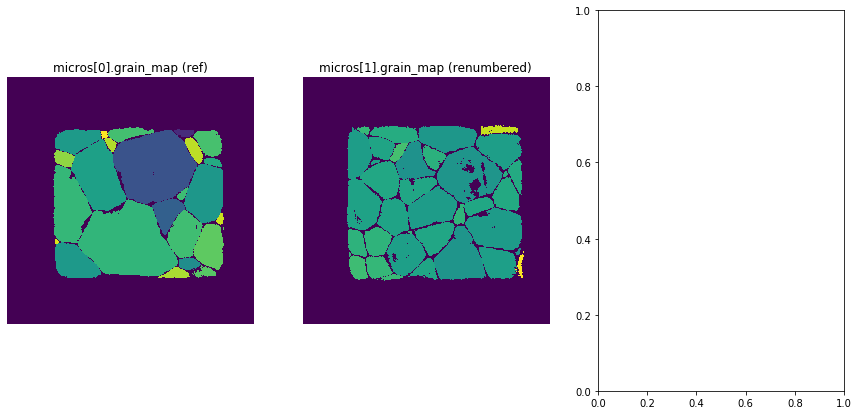

In [5]:
merged_micro = Microstructure.merge_microstructures([micro_botcen, micro], 137, 0.0014, plot=True)

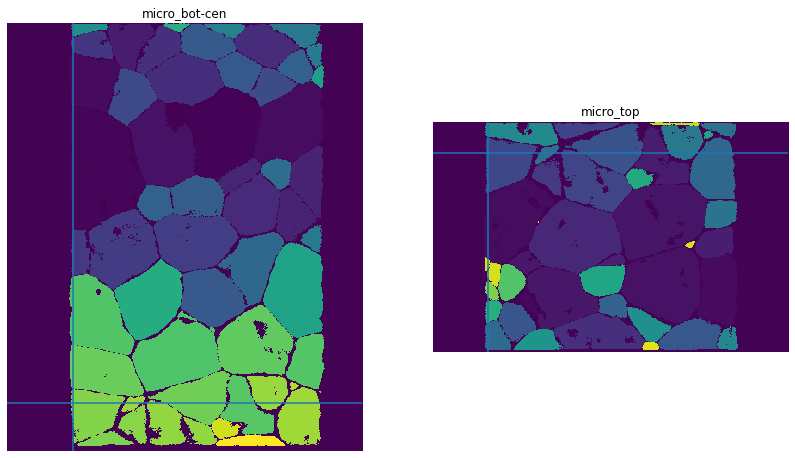

In [57]:
from matplotlib import pyplot as plt, cm
%matplotlib inline

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(micro_botcen.grain_map[:, 320, :].T)
ax1.axhline(y=700)
ax1.axvline(x=120)
plt.axis('off')
plt.title('micro_bot-cen')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(micro.grain_map[:, 320, :].T)
ax2.axhline(y=57)
ax2.axvline(x=100)
plt.axis('off')
plt.title('micro_top')
plt.show()

In [58]:
788 - 455

333